In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

In [3]:
plt.style.use('dark_background')

### Read in Xenium file

In [4]:
xenium_scdata = sc.read_h5ad(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Generate cell type labelings

In [5]:
xenium_filtered_cluster_name_mapping = {
    '0': 'Endo',
    '1': 'Astro',
    '2': 'Astro',
    '3': 'Oligio',
    '4': 'VLMC',
    '5': 'CLUSTER 5',
    '6': 'Oligio',
    '7': 'Meis2 HPF',
    '8': 'L4/5 IT CTX',
    '9': 'L4/5 IT CTX',
    '10': 'L6 CT CTX',
    '11': 'CLUSTER 11',
    '12': 'Micro-PVM',
    '13': 'CLUSTER 13',
    '14': 'CLUSTER 14',
    '15': 'Oligio',
    '16': 'Oligio',
    '17': 'L5/6 IT CTX',
    '18': 'L5 PT CTX',
    '19': 'Sst Chodl',
    '20': 'Oligio',
    '21': 'L2/3 IT AI/ENTI',
    '22': 'Pvalb',
    '23': 'CLUSTER 23',
    '24': 'CLUSTER 24',
    '25': 'VLMC',
    '26': 'Lamp5',
    '27': 'Sst HPF',
    '28': 'CLUSTER 28'
}

In [6]:
# Convert category keys in the dictionary to strings
xenium_filtered_cluster_name_mapping = {str(k): v for k, v in xenium_filtered_cluster_name_mapping.items()}

# Map cluster IDs to cluster names using the updated dictionary
xenium_scdata.obs['cluster_names'] = xenium_scdata.obs['leiden'].astype(str).map(xenium_filtered_cluster_name_mapping)


In [43]:
xenium_scdata.write(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\Xenium_mouse_filtered.h5ad")

### Generate cell type color dictionary

In [11]:
xenium_celltype_list = list(xenium_scdata.obs['cluster_names'].unique())
xenium_celltype_list

['Micro-PVM',
 'L5 PT CTX',
 'Oligio',
 'Astro',
 'Lamp5',
 'L6 CT CTX',
 'VLMC',
 'L4/5 IT CTX',
 'Endo',
 'L5/6 IT CTX',
 'Pvalb',
 'CLUSTER 5',
 'Sst Chodl',
 'CLUSTER 11',
 'CLUSTER 13',
 'CLUSTER 14',
 'L2/3 IT AI/ENTI',
 'Meis2 HPF',
 'CLUSTER 23',
 'CLUSTER 24',
 'Sst HPF',
 'CLUSTER 28']

In [8]:
xenium_color_dict = {
    "0": "#07ba7f",
    "1": "#00FF00",
    "2": "#0000FF",
    "3": "#7B68EE",
    "4": "#00FFFF",
    "5": "#FFFF00",
    "6": "#FF00FF",
    "7": "#FF7A00",
    "8": "#008080",
    "9": "#800000",
    "10": "#008000",
    "11": "#000080",
    "12": "#808080",
    "13": "#C0C0C0",
    "14": "#FFA500",
    "15": "#ADD8E6",
    "16": "#90EE90",
    "17": "#FFB6C1",
    "18": "#FFD700",
    "19": "#FF4500",
    "20": "#ADFF2F",
    "21": "#7B68EE",
    "22": "#00FA9A",
    "23": "#48D1CC",
    "24": "#C71585",
    "25": "#8B4513",
    "26": "#4682B4",
    "27": "#D2B48C",
    "28": "#D8BFD8",
}

In [9]:
xenium_color_list = xenium_color_dict.values()
xenium_color_list

dict_values(['#07ba7f', '#00FF00', '#0000FF', '#7B68EE', '#00FFFF', '#FFFF00', '#FF00FF', '#FF7A00', '#008080', '#800000', '#008000', '#000080', '#808080', '#C0C0C0', '#FFA500', '#ADD8E6', '#90EE90', '#FFB6C1', '#FFD700', '#FF4500', '#ADFF2F', '#7B68EE', '#00FA9A', '#48D1CC', '#C71585', '#8B4513', '#4682B4', '#D2B48C', '#D8BFD8'])

In [12]:
import json
xenium_dict = {}
for celltype, color in zip(xenium_celltype_list, xenium_color_list):
    xenium_dict[celltype] = color
xenium_dict = json.dumps(xenium_dict)
xenium_dict

'{"Micro-PVM": "#07ba7f", "L5 PT CTX": "#00FF00", "Oligio": "#0000FF", "Astro": "#7B68EE", "Lamp5": "#00FFFF", "L6 CT CTX": "#FFFF00", "VLMC": "#FF00FF", "L4/5 IT CTX": "#FF7A00", "Endo": "#008080", "L5/6 IT CTX": "#800000", "Pvalb": "#008000", "CLUSTER 5": "#000080", "Sst Chodl": "#808080", "CLUSTER 11": "#C0C0C0", "CLUSTER 13": "#FFA500", "CLUSTER 14": "#ADD8E6", "L2/3 IT AI/ENTI": "#90EE90", "Meis2 HPF": "#FFB6C1", "CLUSTER 23": "#FFD700", "CLUSTER 24": "#FF4500", "Sst HPF": "#ADFF2F", "CLUSTER 28": "#7B68EE"}'

### Create adata

In [16]:
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [20]:
adata_xenium = Jenie(xenium_scdata, 'xenium_scdata', 'xenium_scdata', pallete = 'xenium')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


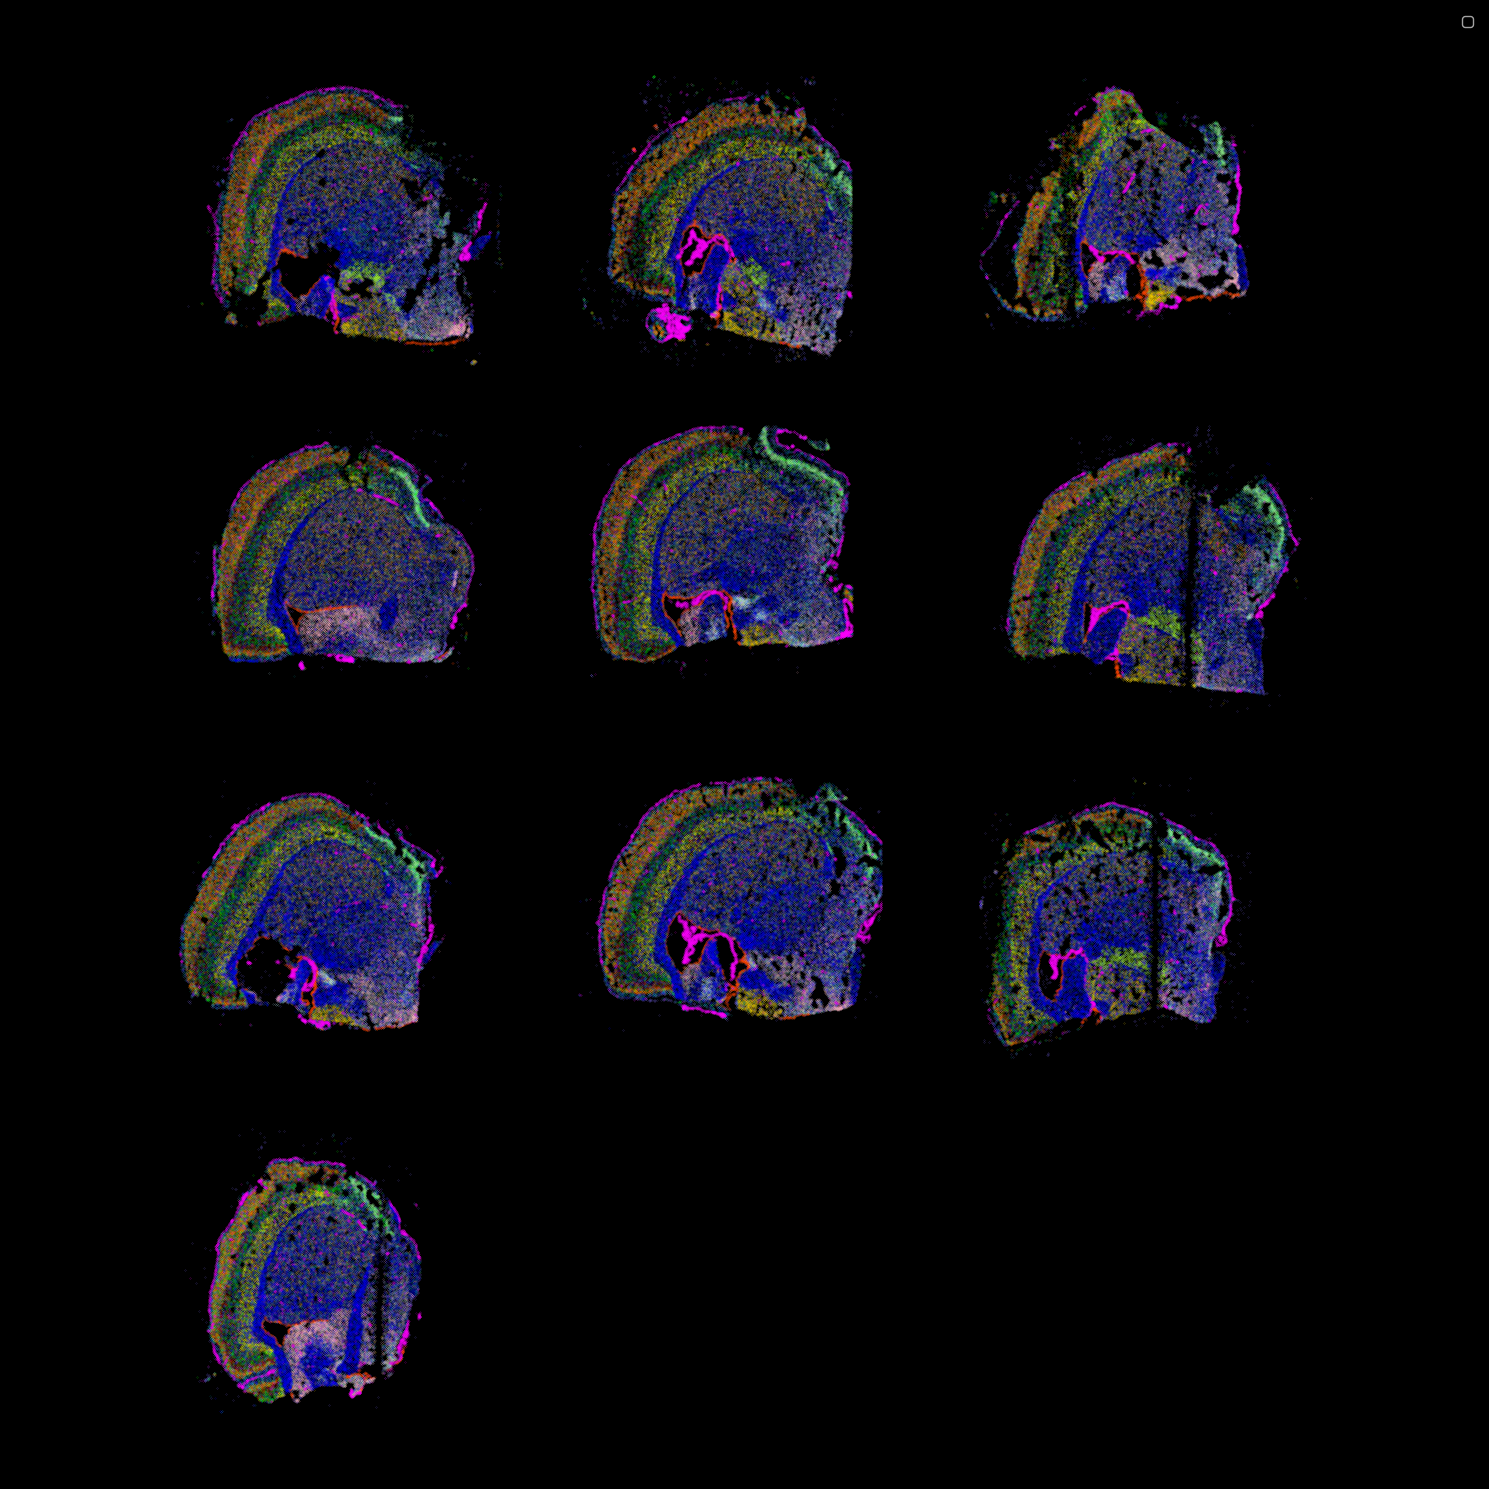

In [31]:
adata_xenium.plot_cluster_all_scdata(group = 'cluster_names', sbig = 0.05)

### Create subset of remaining clusters to be labeled

In [23]:
unlabeled_clusters_array = np.array(['CLUSTER 5',
                                    'CLUSTER 11',
                                    'CLUSTER 13',
                                    'CLUSTER 14',
                                    'CLUSTER 23',
                                    'CLUSTER 24',
                                    'CLUSTER 28'])

In [25]:
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [26]:
xenium_unlabeled_scdata = xenium_scdata[xenium_scdata.obs['cluster_names'].isin(unlabeled_clusters_array)]
xenium_unlabeled_scdata

View of AnnData object with n_obs × n_vars = 101546 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [27]:
adata_xenium_unlabeled = Jenie(xenium_unlabeled_scdata, 'xenium_unlabeled_scdata', 'xenium_unlabeled_scdata', pallete = 'xenium')

### Generate umap

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


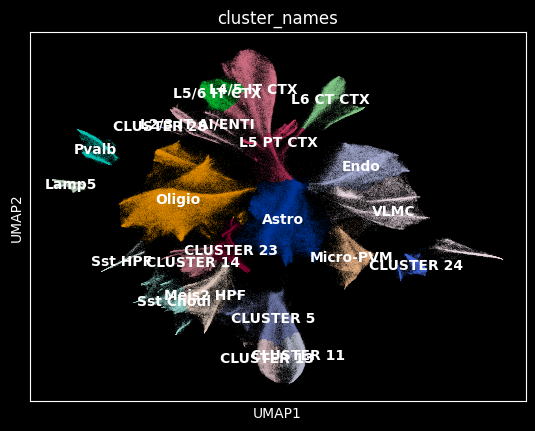

In [42]:
sc.pl.umap(xenium_scdata, color = 'cluster_names', legend_loc = 'on data')

### Clusters 5, 11, 13 brain projection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


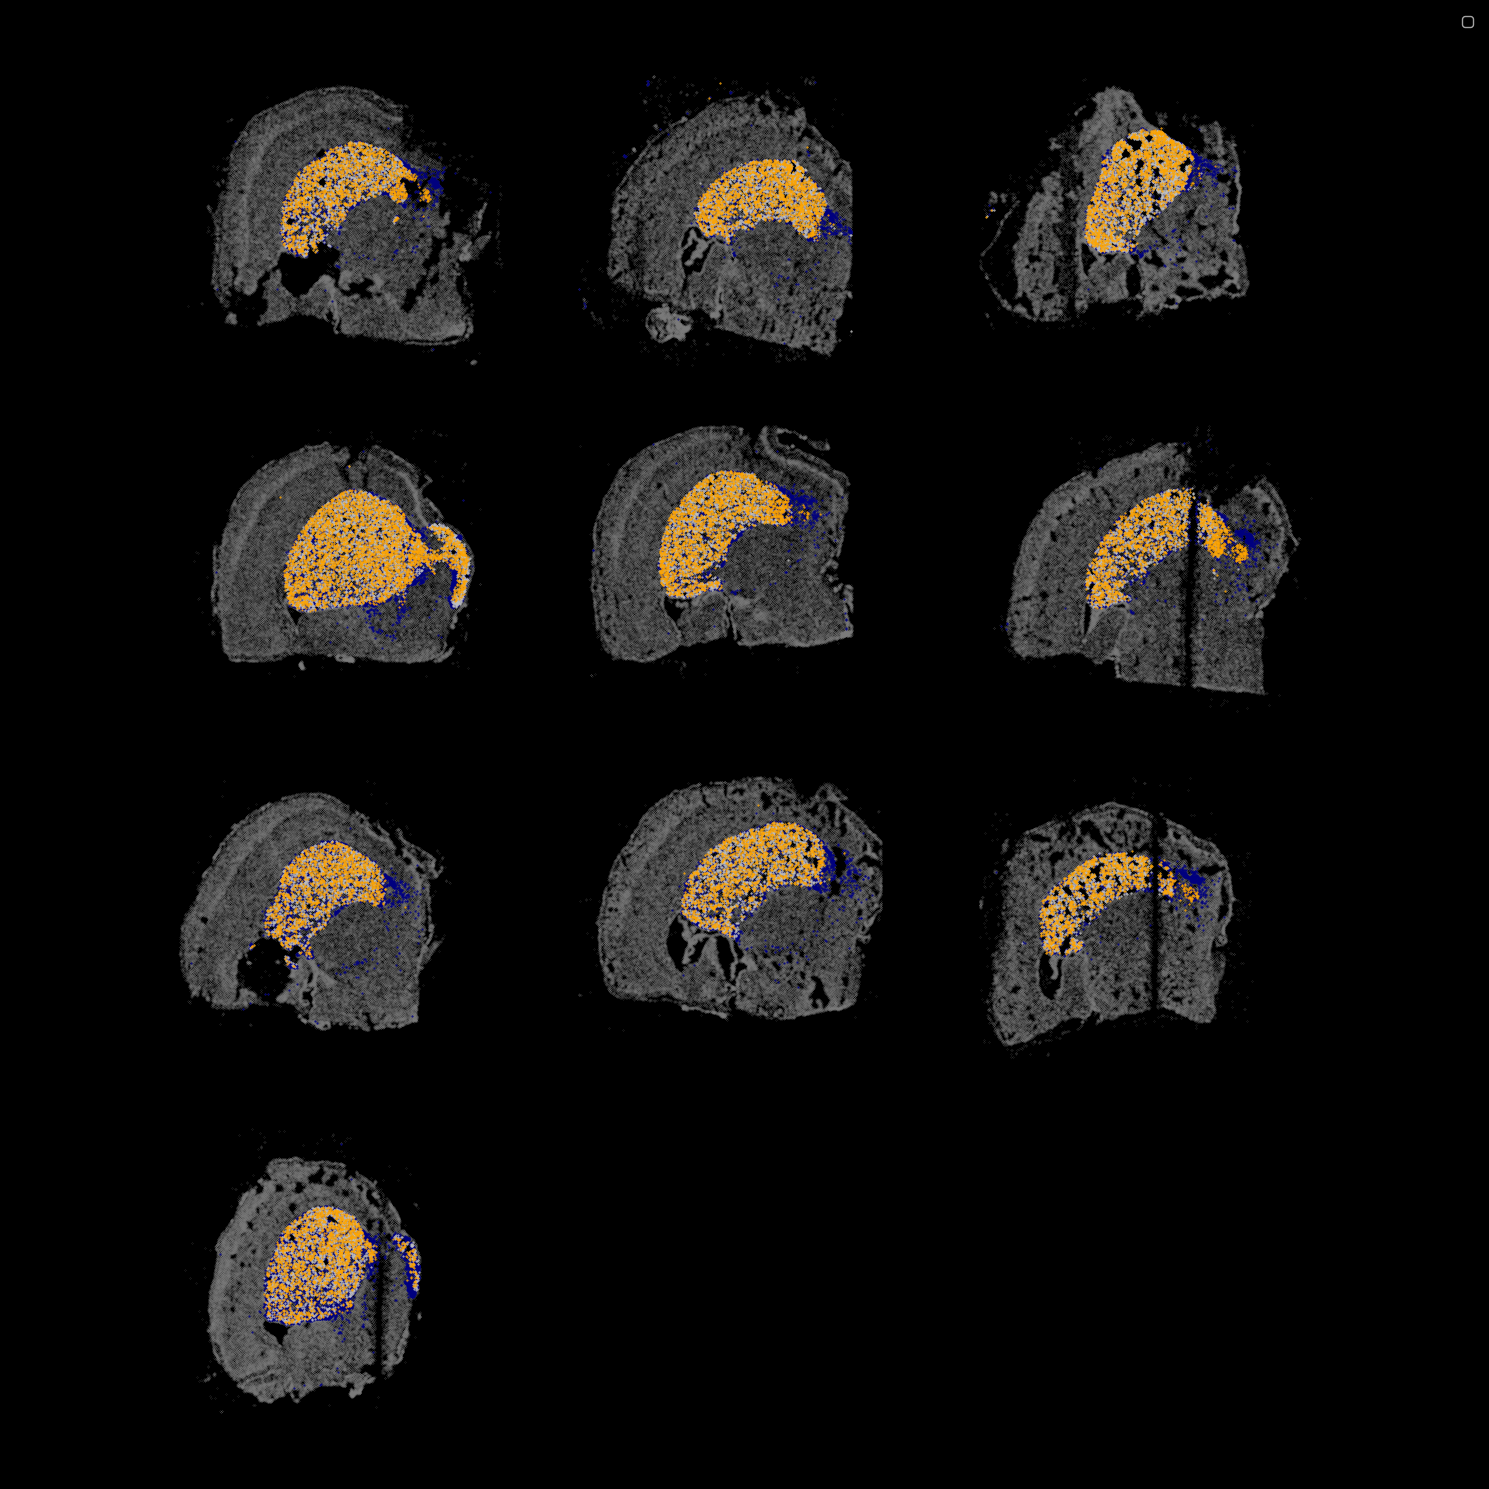

In [36]:
adata_xenium_unlabeled.plot_cluster_all_scdata(group = 'cluster_names', clusters = ['CLUSTER 5','CLUSTER 11','CLUSTER 13'],  ref = adata_xenium, sbig = 1, ssm = 0.05)

### Cluster 14 brain projection map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


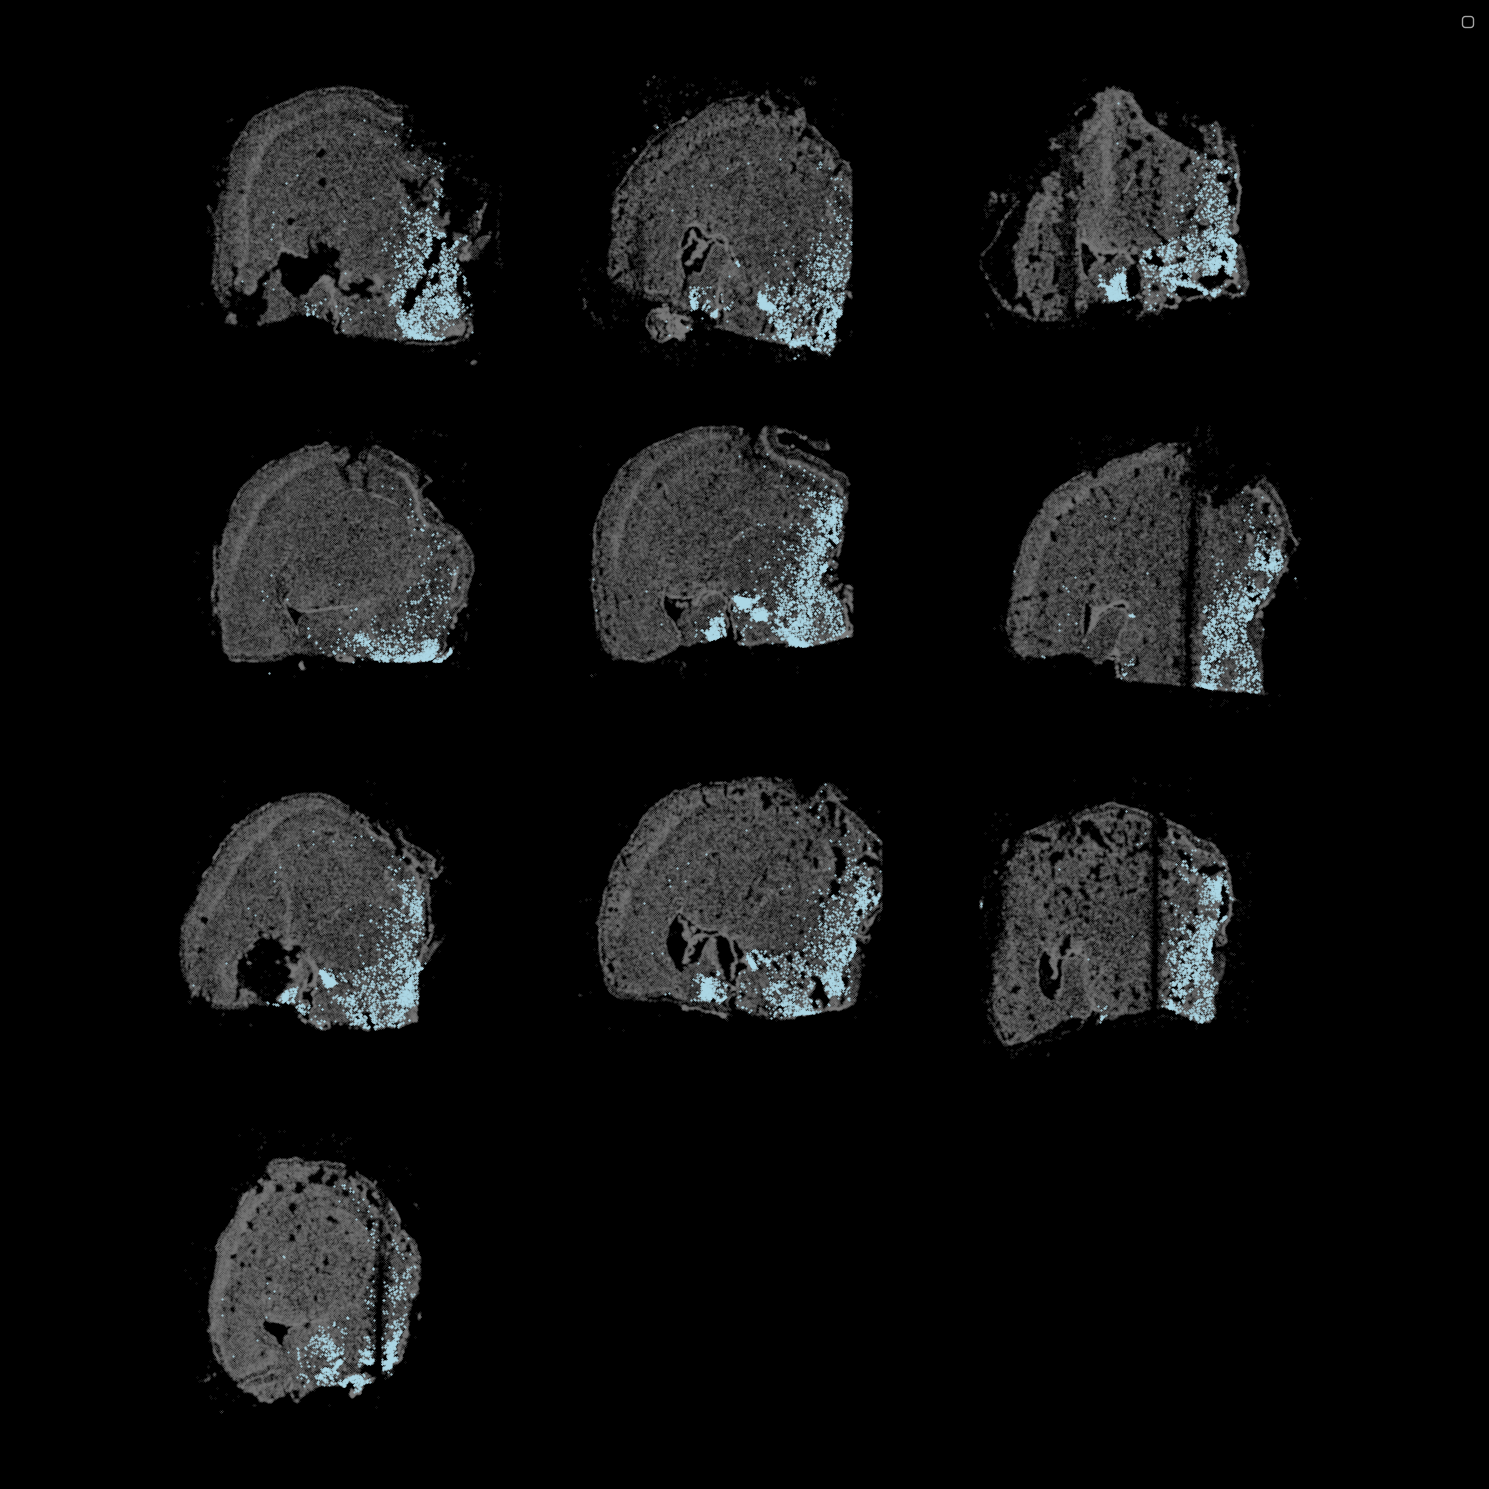

In [38]:
adata_xenium_unlabeled.plot_cluster_all_scdata(group = 'cluster_names', clusters = ['CLUSTER 14'],  ref = adata_xenium, sbig = 1, ssm = 0.05)

### Cluster 23 brain projection map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


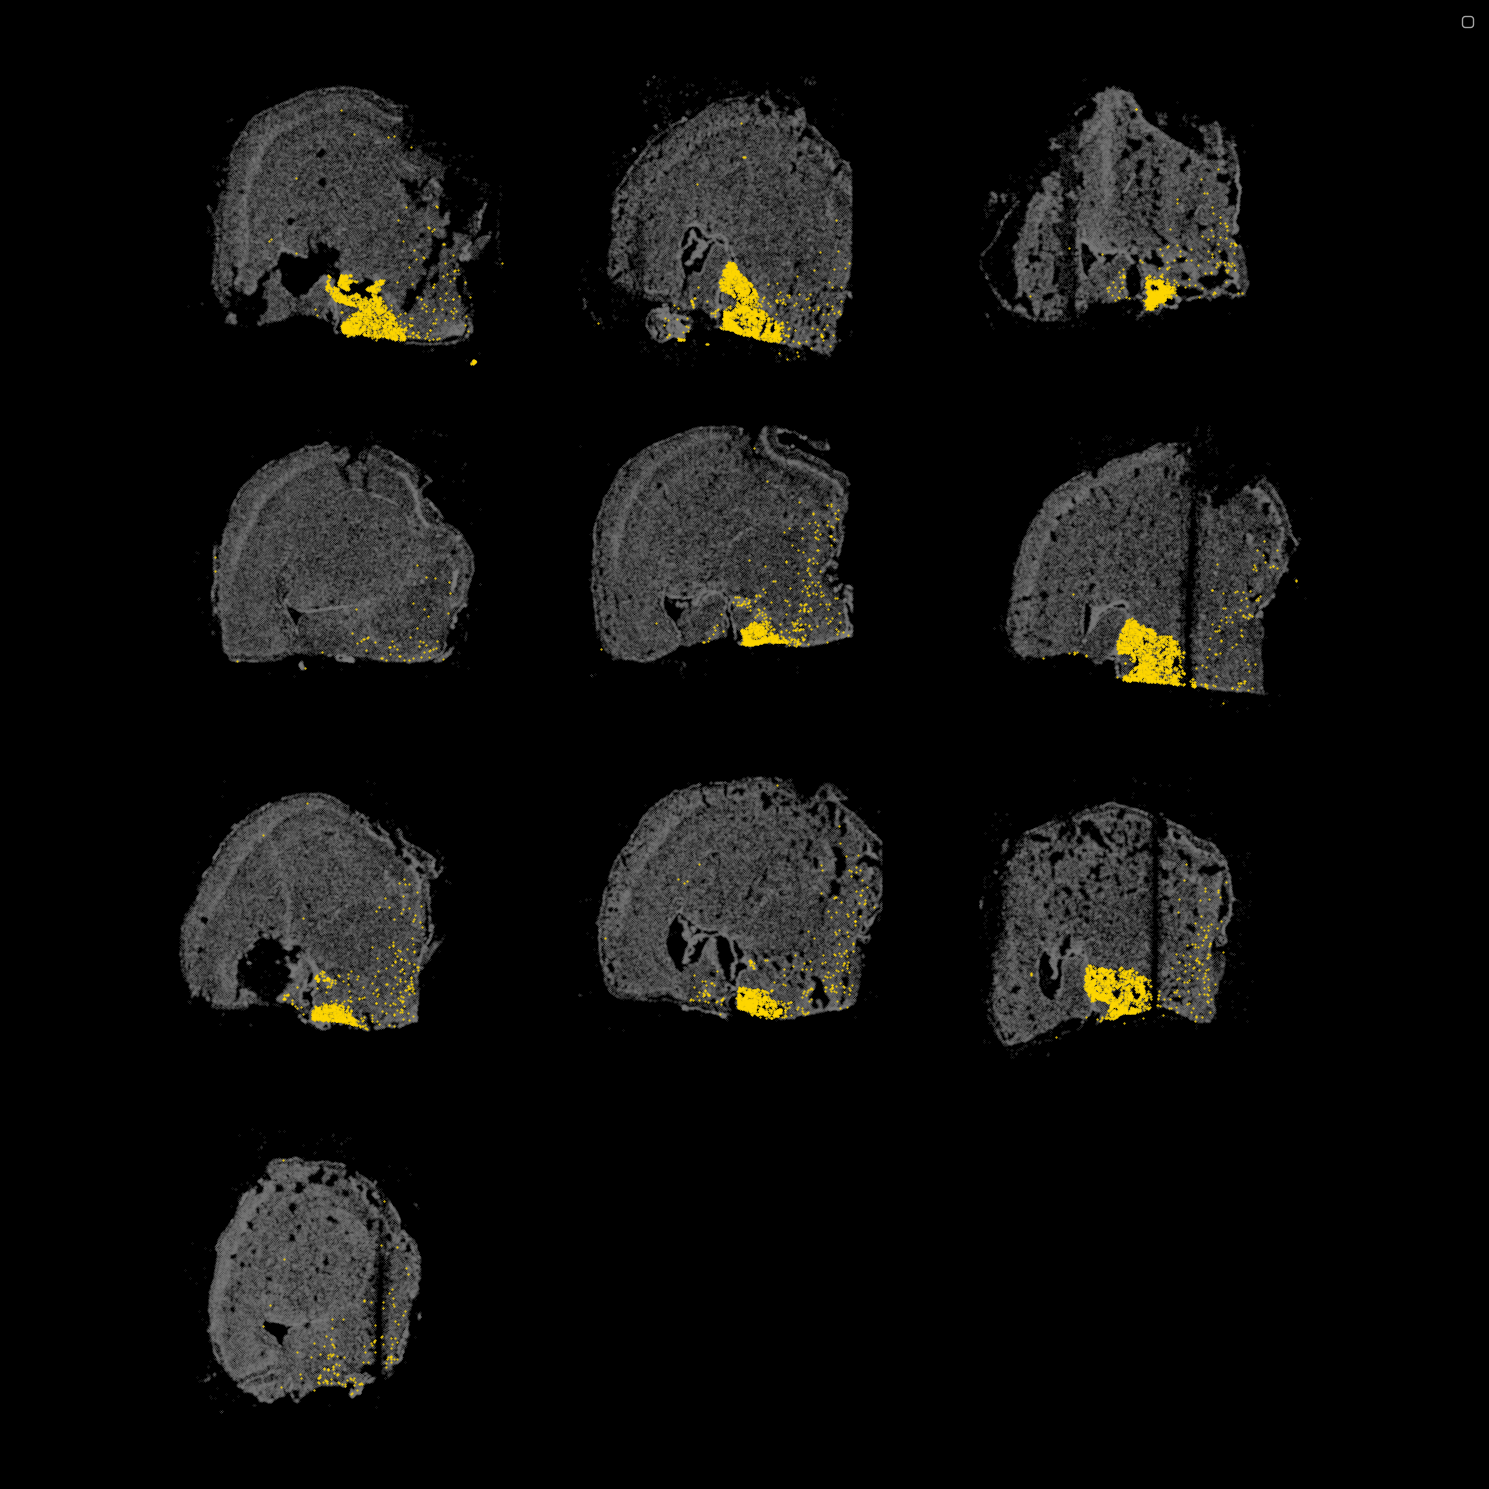

In [39]:
adata_xenium_unlabeled.plot_cluster_all_scdata(group = 'cluster_names', clusters = ['CLUSTER 23'],  ref = adata_xenium, sbig = 1, ssm = 0.05)

### Cluster 24 brain projection map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


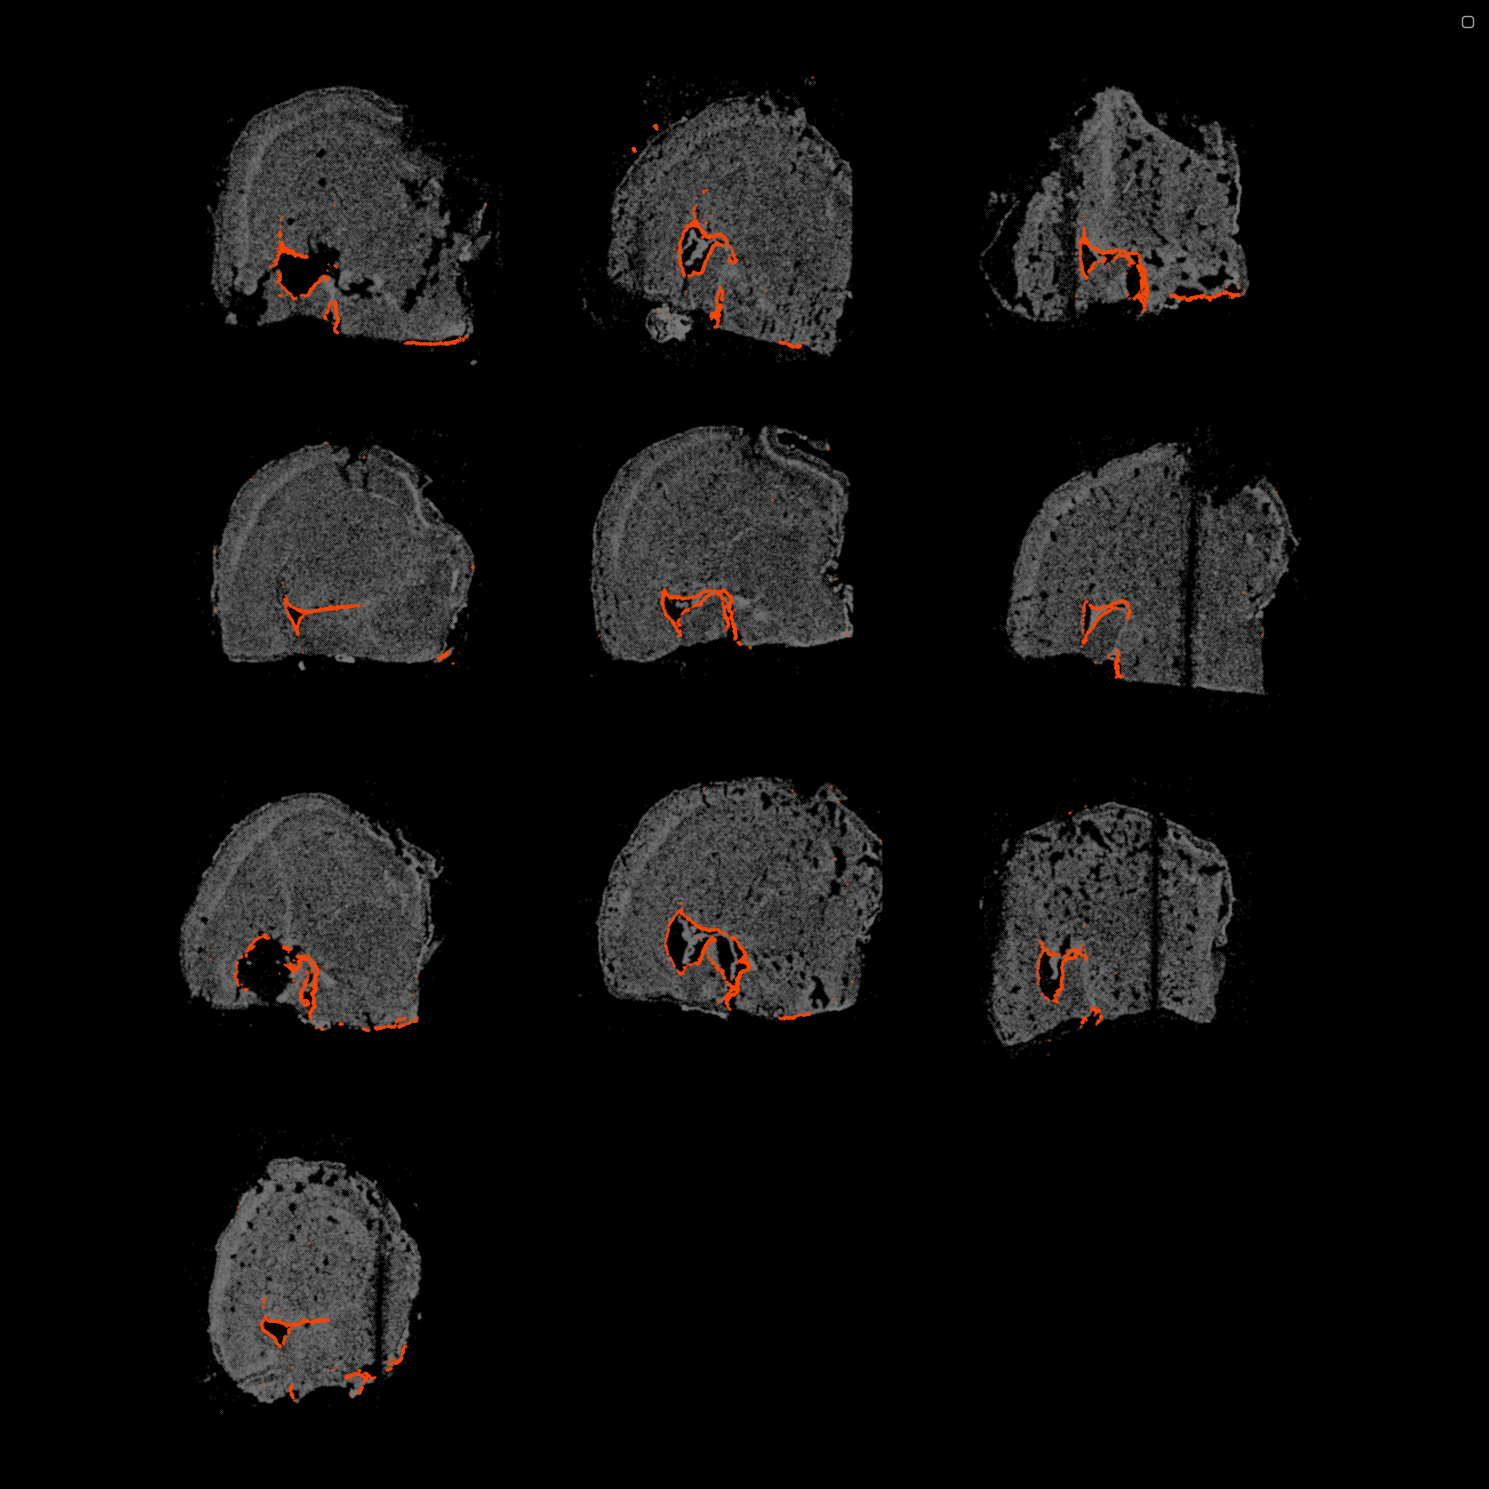

In [40]:
adata_xenium_unlabeled.plot_cluster_all_scdata(group = 'cluster_names', clusters = ['CLUSTER 24'],  ref = adata_xenium, sbig = 1, ssm = 0.05)

### Cluster 28 brain projection map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


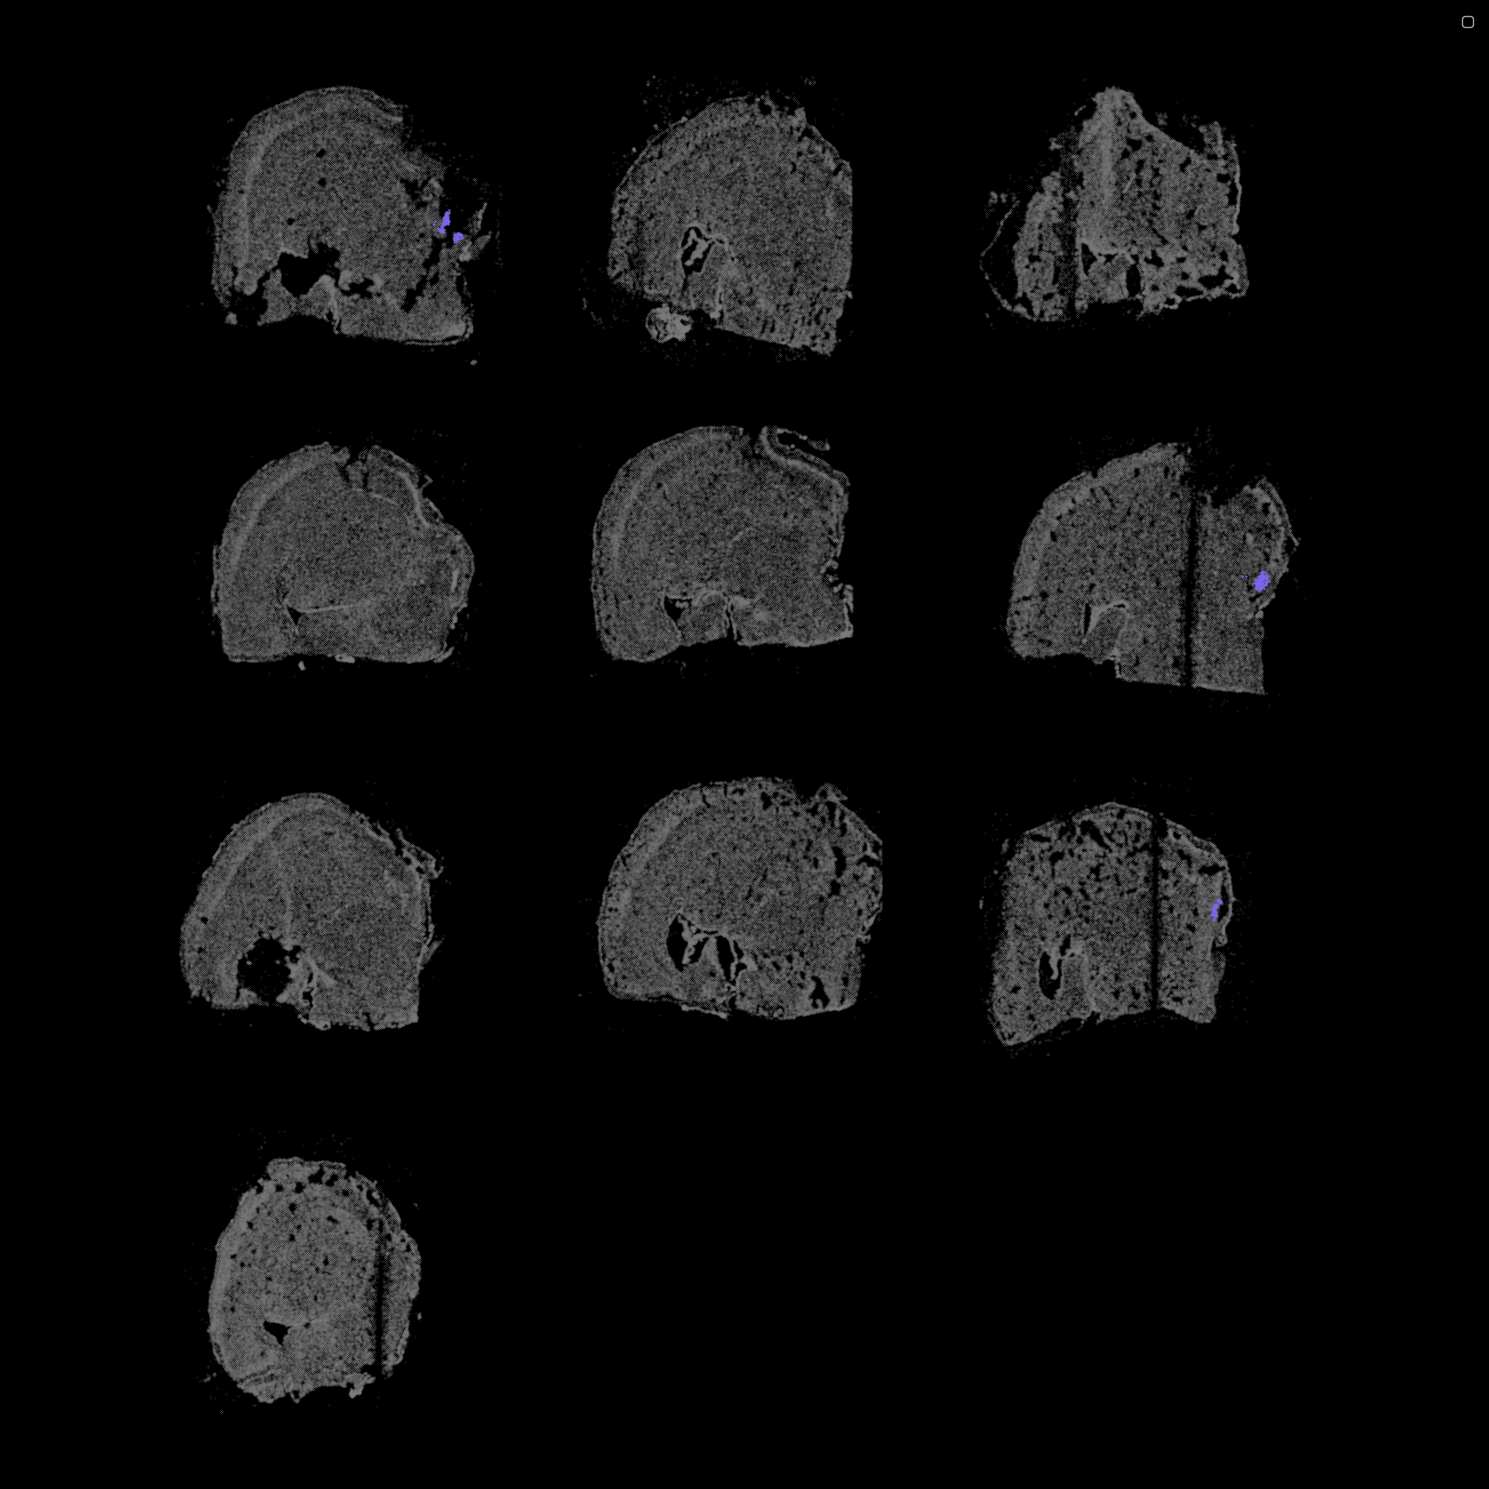

In [41]:
adata_xenium_unlabeled.plot_cluster_all_scdata(group = 'cluster_names', clusters = ['CLUSTER 28'],  ref = adata_xenium, sbig = 1, ssm = 0.05)